In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from itertools import product
import os
from joblib import Parallel, delayed
from pushbullet import Pushbullet
from dotenv import load_dotenv
import statsmodels.api as sm
from scipy.stats import norm, kstest
from sklearn.decomposition import PCA
import matplotlib.cm as cm

load_dotenv()

API_KEY = os.getenv("API_KEY")


In [2]:

files = [f for f in os.listdir() if f.endswith('.csv')]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df.to_csv('all.csv', index=False)

df.info()
df.drop_duplicates(inplace=True)
df.notna().sum()
df.head()

df = df.sample(20000)

model_names = {
    "K-means": KMeans(),
    "Hierarchical": AgglomerativeClustering(),
}

model_params = {
    "K-means": {"n_clusters": [2, 3, 4, 5, 10, 20]},
    "Hierarchical": {"n_clusters": [2, 3, 4, 5, 10, 20]},
}

def remove_outliers(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    return df[(z_scores < threshold).all(axis=1)]

df_clean = remove_outliers(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20667138 entries, 0 to 20667137
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       float64
 1   y       float64
 2   z       float64
 3   vx      float64
 4   vy      float64
 5   vz      float64
 6   m       float64
 7   id      int64  
dtypes: float64(7), int64(1)
memory usage: 1.2 GB


In [3]:

results = []
try:
    for model_name, model in model_names.items():
        param_grid = model_params[model_name]
        keys, values = zip(*param_grid.items())
        for combination in product(*values):
            params = dict(zip(keys, combination))
            pipe = make_pipeline(StandardScaler(), model)
            step_name = list(pipe.named_steps.keys())[-1]
            param_dict = {f'{step_name.lower()}__{k}': v for k, v in params.items()}
            pipe.set_params(**param_dict)
            pipe.fit(df_clean)
            if model_name in ["DBSCAN", "OPTICS"]:
                labels = pipe.named_steps[step_name].fit_predict(df_clean)
            else:
                labels = pipe.named_steps[step_name].labels_
            score = silhouette_score(df_clean, labels)
            results.append({"model": model_name, "params": params, "score": score})
except Exception as e:
    print(e)
    print(f"Error with model {model_name} and params {params}")
    try:
        pb = Pushbullet(API_KEY)
        push = pb.push_note(f"Error with model {model_name} and params {params}", "Error")
    except Exception as e:
        print("there was an error with pushbullet", e)


In [4]:

results_df = pd.DataFrame(results)
best_model = results_df.groupby('model')['score'].mean().idxmax()
best_params = results_df[results_df['model'] == best_model]['params'].iloc[0]
step_name = 'kmeans' if best_model == 'K-means' else 'agglomerativeclustering'
prefixed_best_params = {f"{step_name}__{key}": value for key, value in best_params.items()}

if best_model == 'K-means':
    model = KMeans()
else:
    model = AgglomerativeClustering()

pipe = make_pipeline(StandardScaler(), model)
pipe.set_params(**prefixed_best_params)
pipe.fit(df)
labels = pipe.named_steps[step_name].labels_
results_df.head(5)


,model,params,score
0,K-means,{'n_clusters': 2},0.620359
1,K-means,{'n_clusters': 3},-0.043210
2,K-means,{'n_clusters': 4},-0.042554
3,K-means,{'n_clusters': 5},-0.080746
4,K-means,{'n_clusters': 10},-0.192970


In [ ]:
#saving the best model
import joblib
joblib.dump(pipe, 'best_model.pkl')

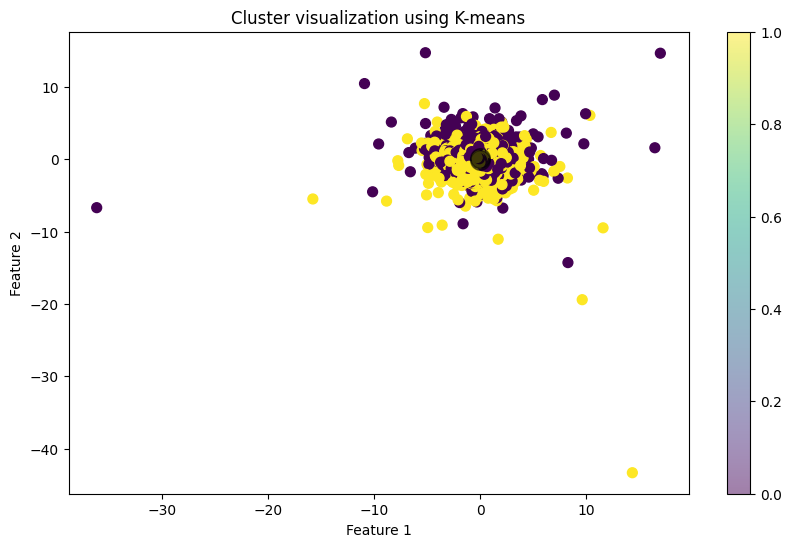

In [5]:

plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, s=50, cmap='viridis')
if best_model == "K-means":
    centers = pipe.named_steps[step_name].cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title(f'Cluster visualization using {best_model}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()


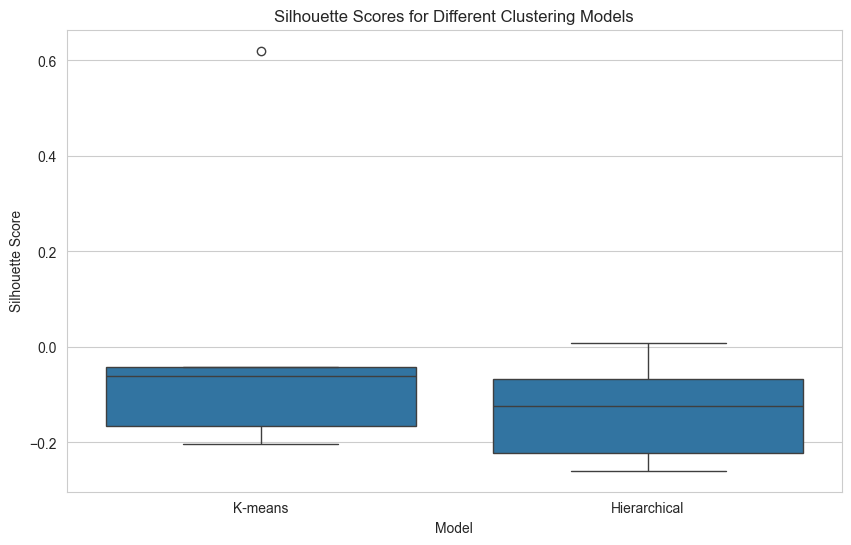

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="score", data=results_df)
plt.title("Silhouette Scores for Different Clustering Models")
plt.ylabel("Silhouette Score")
plt.xlabel("Model")
plt.show()


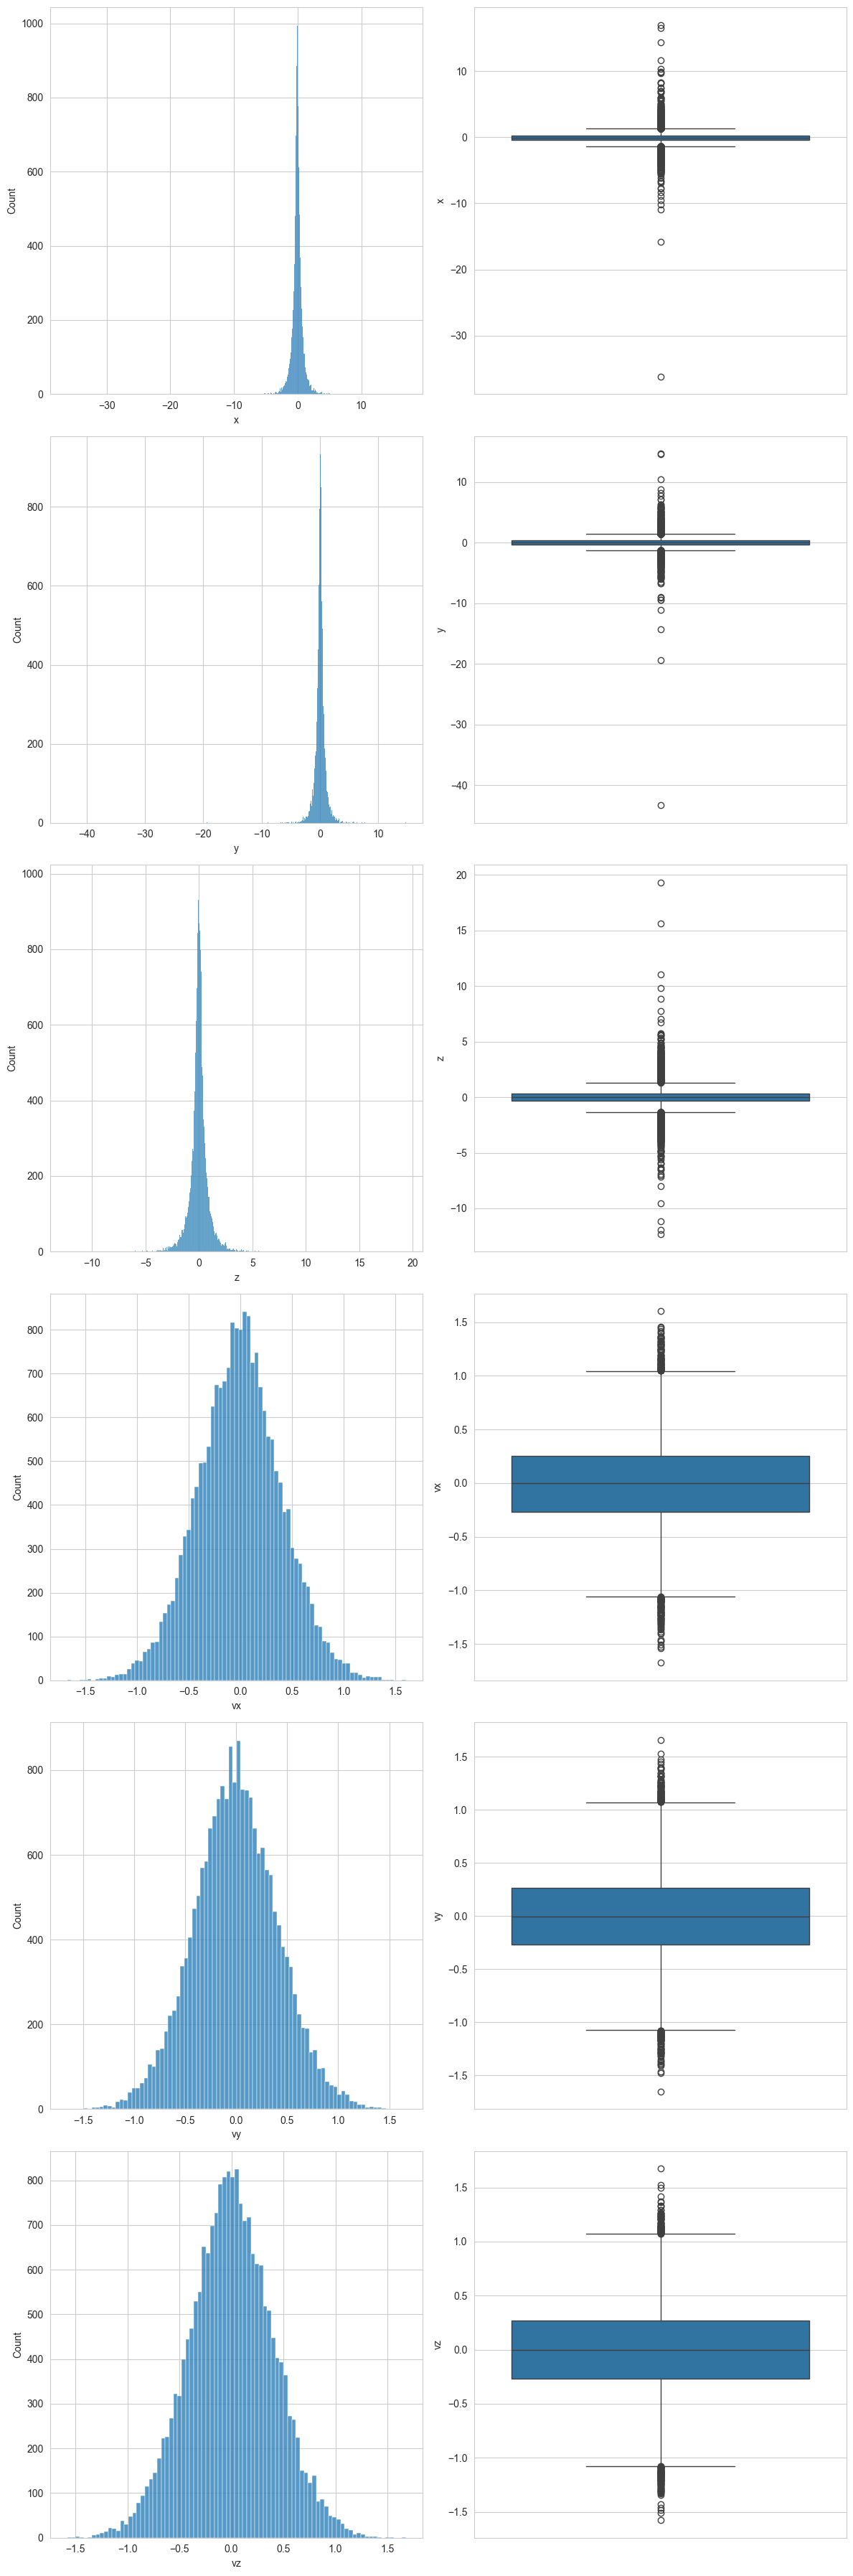

In [7]:
# Ensure the required columns are present in the DataFrame
required_columns = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'm', 'id']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"Missing columns in DataFrame: {missing_columns}")
else:
    slim_df = df.drop(['m', 'id'], axis=1).reset_index(drop=True)

    variable_list = slim_df.columns.tolist()
    fig, ax = plt.subplots(len(variable_list), 2, figsize=(12, 36))

    for idx, variable in enumerate(variable_list):
        axes_hist = ax[idx][0]
        axes_box  = ax[idx][1]
        sns.histplot(data=slim_df, x=variable, ax=axes_hist)
        sns.boxplot(data=slim_df, y=variable, ax=axes_box)

    plt.tight_layout()
    plt.show()

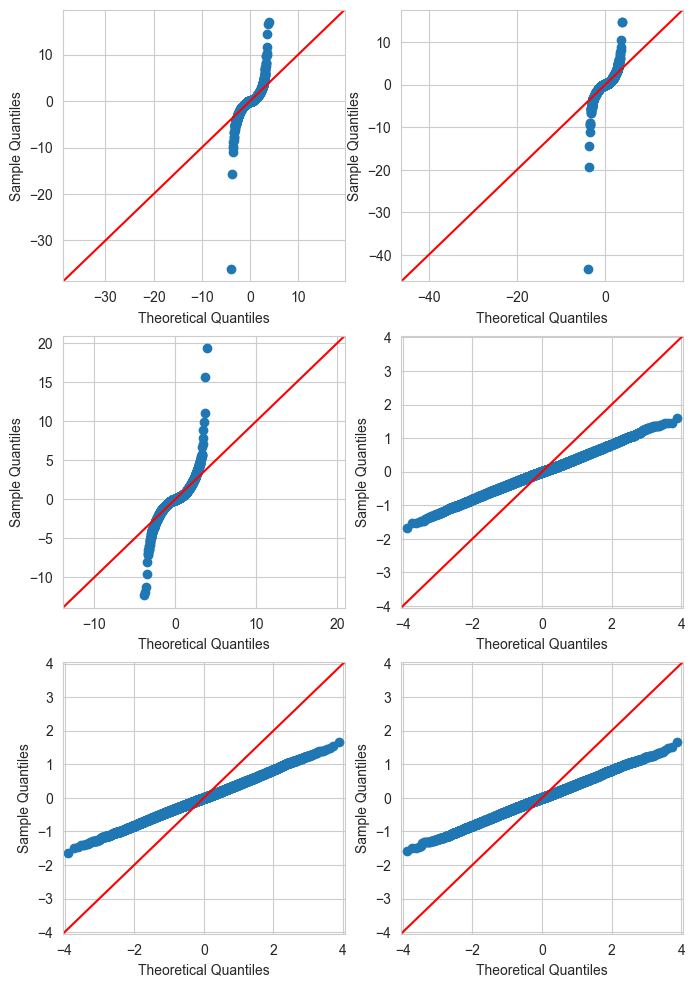

In [8]:


fig2, ax2 = plt.subplots(len(variable_list) // 2, 2, figsize=(8, 12))

for idx, variable in enumerate(variable_list):
    ax = ax2[idx // 2][idx % 2]
    sm.qqplot(slim_df[variable], line='45', ax=ax)


<Axes: xlabel='vz', ylabel='Count'>

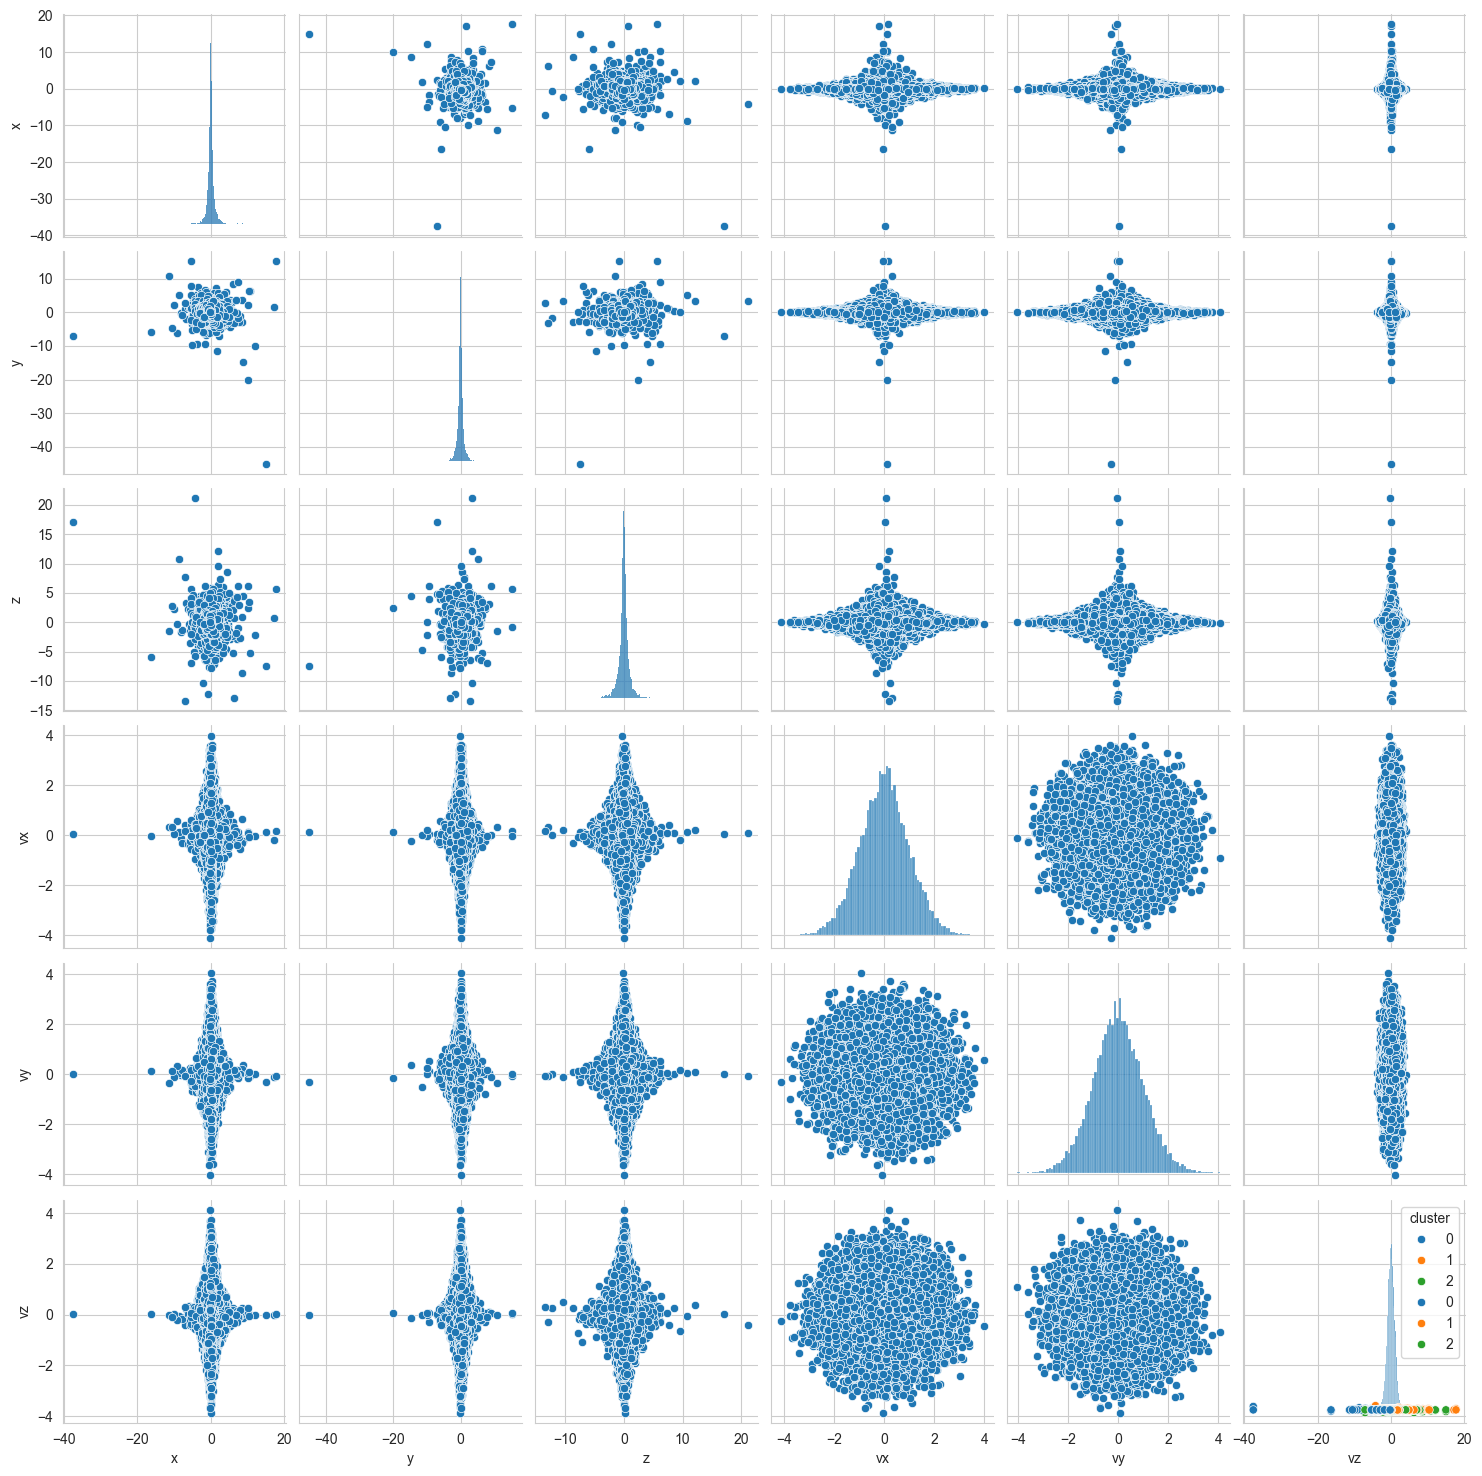

In [9]:

scaler = StandardScaler()
scaled_array = scaler.fit_transform(slim_df)
scaled_df = pd.DataFrame(scaled_array, columns=slim_df.columns)

sns.pairplot(data=scaled_df)


kmeans = KMeans(n_clusters=3, random_state=101)
kmeans.fit(scaled_df)
scaled_df['cluster'] = kmeans.predict(scaled_df)

sns.scatterplot(data=scaled_df, x='x', y='z', hue='cluster', palette='tab10')
sns.scatterplot(data=scaled_df, x='x', y='vx', hue='cluster', palette='tab10')


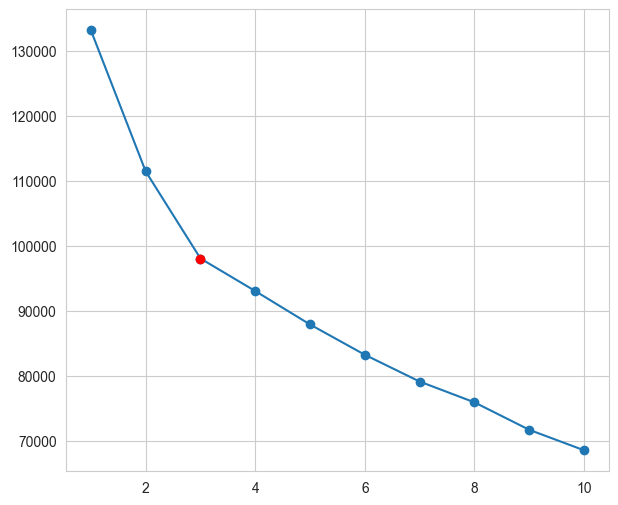

In [10]:

cluster_sizes = list(range(1, 11))
inertias = {}

for n_clusters in cluster_sizes:
    kmeans_v = KMeans(n_clusters=n_clusters)
    kmeans_v.fit(scaled_df)
    inertias[n_clusters] = kmeans_v.inertia_

plt.figure(figsize=(7, 6))
plt.plot(inertias.keys(), inertias.values(), 'o-')
pointsx = [3]
for pointx in pointsx:
    inertia = inertias[pointx]
    plt.plot([pointx], [inertia], 'ro')


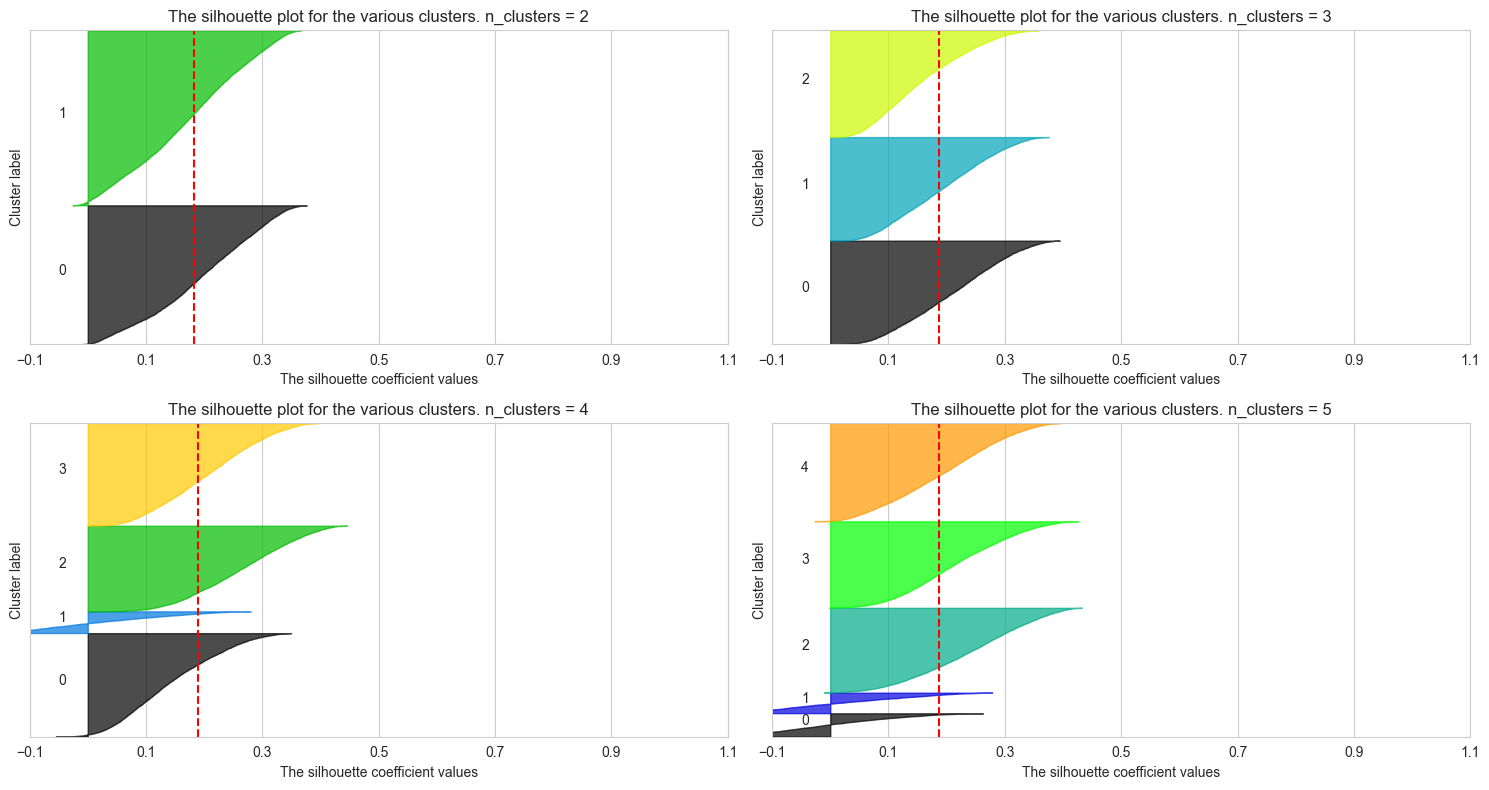

In [11]:


fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for idx, n_clusters in enumerate([2, 3, 4, 5]):
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
    cluster_labels = km.fit_predict(scaled_df)

    silhouette_avg = silhouette_score(scaled_df, cluster_labels)
    sample_silhouette_values = silhouette_samples(scaled_df, cluster_labels)

    q, mod = divmod(idx, 2)
    ax[q][mod].set_xlim([-0.1, 1])
    ax[q][mod].set_ylim([0, len(scaled_df) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[q][mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax[q][mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax[q][mod].set_title(f"The silhouette plot for the various clusters. n_clusters = {n_clusters}")
    ax[q][mod].set_xlabel("The silhouette coefficient values")
    ax[q][mod].set_ylabel("Cluster label")

    ax[q][mod].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax[q][mod].set_yticks([])
    ax[q][mod].set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.tight_layout()
plt.show()


<Axes: xlabel='C1', ylabel='C2'>

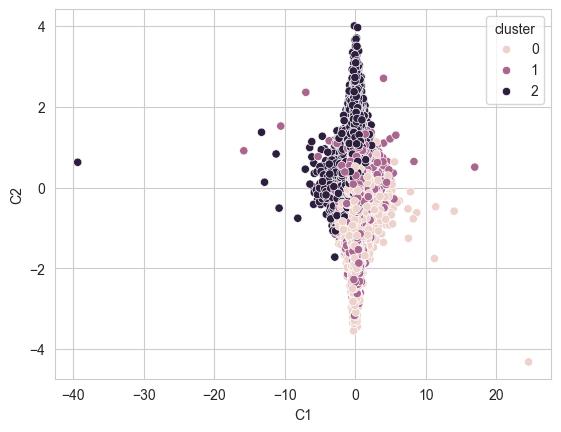

In [12]:

pca = PCA(n_components=2)
pca_df = pca.fit_transform(scaled_df.drop('cluster', axis=1))
pca_df = pd.DataFrame(pca_df, columns=['C1', 'C2'])
pca_df['cluster'] = scaled_df['cluster']

pca.explained_variance_ratio_

sns.scatterplot(data=pca_df, x='C1', y='C2', hue='cluster')